# Soda Bottle Identification

We're going to use convolutional neural networks (CNNs) to allow the computer to recognize over 8 different soda bottle types as part of the Soda Bottle Classification Challenge. This notebook uses concepts learned in the fastai course, specifically:
1. How to find the learning rate
2. Use of precomputed activations
3. Application of data augmentation
4. Test-time Augmentation for increasing accuracy

## Library Imports

There are 5769 images of soda bottles in 8 different classes

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [4]:
PATH = "data/sodabottle/"
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [5]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [6]:
torch.backends.cudnn.enabled

True

## First look at Soda Bottle Pictures

Our library will assume that you have *train* directory. A *train.csv* file contains the label of each image. A set of validation indices are chosen here.

In [9]:
os.listdir(PATH)

['tmp', 'train.zip', 'train', 'train.csv']

In [10]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [11]:
label_df = pd.read_csv(label_csv)

In [12]:
label_df.head()

,id,Label
0,0.jpg,P.Zero
1,1.jpg,P.Zero
2,2.jpg,P.Zero
3,3.jpg,P.Zero
4,4.jpg,P.Zero


In [13]:
label_df.columns

Index(['id', 'Label'], dtype='object')

In [14]:
label_df.pivot_table(index='Label', aggfunc=len).sort_values('id', ascending=False)

,id
Label,
P.diet,858
MD.Diet,855
MD.Orig,854
P.Rsugar,850
M.Beer,843
P.Zero,836
P.Cherry,796
P.Orig,727


Here is how the raw data looks like

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnext101</b> model. resnext101 is a version of the model built by Facebook Research. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [15]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [16]:
arch = resnext101
sz = 224
bs = 32

In [17]:
#tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
tfms = tfms_from_model(arch, sz)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', val_idxs=val_idxs, tfms = tfms, bs = bs)

In [18]:
fn = PATH + data.trn_ds.fnames[0];fn

'data/sodabottle/train/0.jpg'

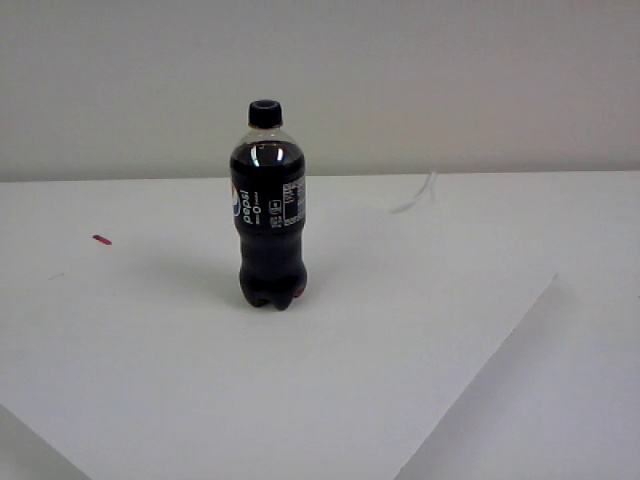

In [19]:
img = PIL.Image.open(fn); img

In [20]:
img.size

(640, 480)

In [21]:
len(data.trn_ds)

5296

In [22]:
len(data.classes), data.classes[:8]

(8,
 ['M.Beer',
  'MD.Diet',
  'MD.Orig',
  'P.Cherry',
  'P.Orig',
  'P.Rsugar',
  'P.Zero',
  'P.diet'])

Data is passed without any augmentation

In [23]:
def get_data(sz, bs):
    #tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom=1.1)
    tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', val_idxs=val_idxs, 
                                       tfms = tfms, bs= bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [24]:
data = get_data(sz, bs)

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute = True, ps=0.5)

In [26]:
lrf=learn.lr_find()

 73%|███████▎  | 122/166 [00:02<00:00, 56.89it/s, loss=6.44]


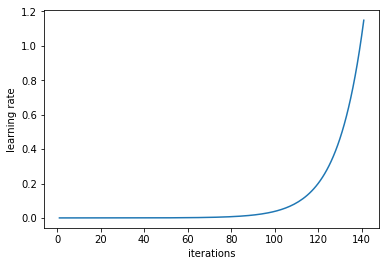

In [27]:
learn.sched.plot_lr()

Learning Rate of 0.03 is chosen as at that rate, the loss is still falling rapidly.

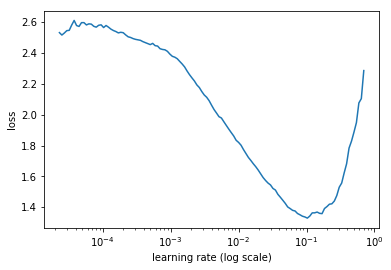

In [28]:
learn.sched.plot()

In [29]:
learn.fit(0.03, 4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.610392   0.25476    0.917611  
    1      0.373792   0.203702   0.927438                    
    2      0.327016   0.128842   0.962963                    
    3      0.26389    0.125802   0.965986                    



[array([0.1258]), 0.9659863945578231]

In [30]:
learn.precompute = False

In [31]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom=1.1)
    #tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', val_idxs=val_idxs, 
                                       tfms = tfms, bs= bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [32]:
data = get_data(sz, bs)

In [33]:
learn.fit(0.03, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.290858   0.105295   0.969766  
    1      0.249638   0.107908   0.972789                    



[array([0.10791]), 0.9727891156462585]

In [34]:
learn.unfreeze()

In [35]:
lr=np.array([0.0003,0.0003,0.03])

In [36]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.208073   0.09548    0.976568  
    1      0.133651   0.066203   0.984883                    
    2      0.088515   0.062513   0.98715                      
    3      0.099246   0.068679   0.981859                     
    4      0.058039   0.053789   0.989418                     
    5      0.039598   0.055181   0.98715                      
    6      0.046372   0.051528   0.990174                     



[array([0.05153]), 0.9901738473167044]

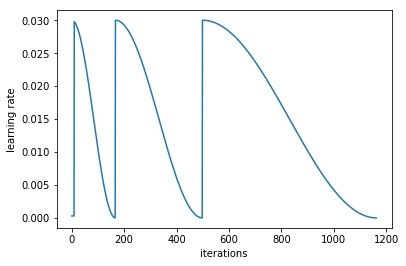

In [37]:
learn.sched.plot_lr()

In [38]:
learn.save('224_pre')

In [39]:
learn.load('224_pre') 

In [40]:
from sklearn import metrics

In [41]:
log_preds,y = learn.TTA()

In [42]:
probs = np.mean(np.exp(log_preds),0)

In [43]:
accuracy_np(probs, y)

0.9894179894179894

In [44]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[163   0   0   0   0   0   0   1]
 [  0 161   1   0   0   0   0   0]
 [  0   1 167   0   0   0   0   1]
 [  1   0   0 151   1   0   0   0]
 [  0   0   0   1 149   0   0   0]
 [  0   0   0   0   3 168   0   0]
 [  0   0   0   0   0   2 180   0]
 [  0   0   1   0   0   0   1 170]]


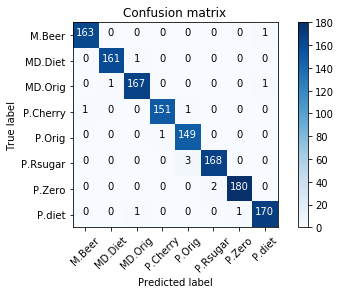

In [46]:
plot_confusion_matrix(cm, data.classes)

In [47]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [48]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

Most incorrect soda


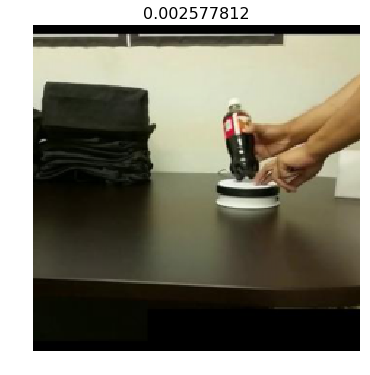

In [49]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect soda")

Most correct soda


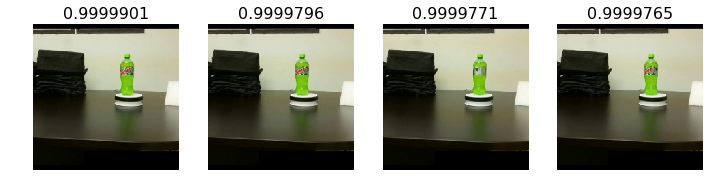

In [50]:
plot_val_with_title(most_by_correct(1, True), "Most correct soda")

Incorrectly classified


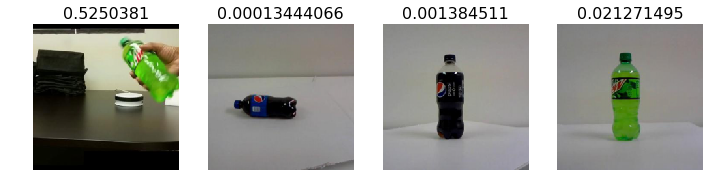

In [51]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Correctly classified


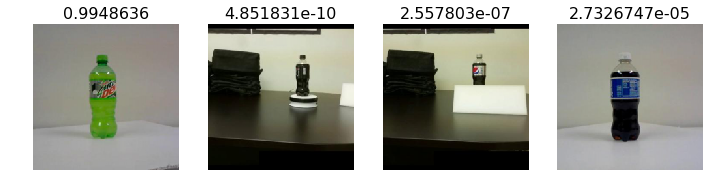

In [52]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")